# 베이지안 최적화 기반 하이퍼 파라미터 튜닝


* Grid Search 단점
  - 튜닝해야 할 하이퍼 파라미터 개수가 많을 경우 최적화 수행 시간 오래 걸림
  - 개별 하이퍼 파라미터 값의 범위가 넓거나 학습 데이터가 대용량일 경우에는 최저고하 시간이 더욱 늘어남
  - XGBoost, LightGBM은 하이퍼 파라미터 개수가 다른 알고리즘에 비해 많기 때문에, 여기다가 대용량 학습 데이터를 사용한단 점까지 더해지면 아주 많은 시간이 소모될 수밖에 없음...

→ **베이지안 최적화** 사용

 **베이지안 최적화**
- 블랙 박스 형태의 함수
- 베이지안 확률에 기반을 둠
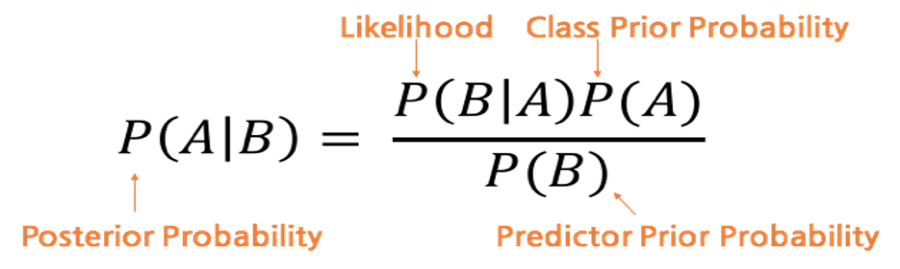
- 즉, 새로운 데이터를 입력 받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수 모델을 만들어 내는 방식

**주요 구성 요소**
- Surrogate Model (대체 모델)
  - Acquisition Function으로부터 최적 함수를 에측할 수 있는 입력값을 추천 받은 뒤 이를 기반으로 최적 함수 모델을 개선해감.

-  Acquisition Function (획득 함수)
  - 개선된 대체 모델을 기반으로 최적 입력값을 계산.

**베이지안 최적화 순서**
1. 랜덤하게 하이퍼 파라미터들을 샘플링하고 성능 결과 관측
2. 관측된 값을 기반으로 대체 모델이 최적 함수 추정
3. 추정된 최적 함수를 기반으로, 획득 함수는 다음으로 관측할 하이퍼 파라미터 값 계산. 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아서 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달
4. 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델 갱신. 다시 최적 함수 예측 추정...

3, 4 반복


### HyperOpt

대체 모델은 최적 함수를 추정할 때 다양한 알고리즘을 사용할 수 있음. 보통 Gaussian Process를 적용하지만, 우리가 사용할 HyperOpt는 트리 파르젠 Estimator(TPE, Tree-structure Parzen Estimator)를 사용함.

In [ ]:
#pip install hyperopt

**HyperOpt를 활용하는 주요 로직**
- 입력 변수명과 입력값의 검색 공간(Search Space) 설정
- 목적 함수(Objective Function) 설정
- 목적 함수의 반환 **최솟값**을 가지는 최적 입력값 유추 (다른 패키지는 목적 함수 반환 값의 최댓값을 가지는 최적 입력값을 유추함)

In [ ]:
import hyperopt

print(hyperopt.__version__)

0.2.7


hp로 입력값의 검색 공간을 설정해보겠음.. 입력 변수명과 입력값 검색 공간은 딕셔너리 형태로 설정되어야 하고, key 값으로 입력 변수명, value 값으로 해당 입력 변수의 검색 공간이 주어짐.

입력값의 검색 공간을 제공하는 대표적인 함수들
- **hp.quniform(label, low, high, q)**: label로 지정된 입력값 변수 검색 공간을 최솟값 low부터 최댓값 high까지 q 간격으로 설정.
- **hp.uniform(label, low, high)**: low~hign까지 정규 분포 형태의 검색 공간 설정.
- **hp.randint(label, upper)**: 0~upper까지 random한 int 값으로 검색 공간 설정.
- **hp.loguniform(label, low, high)**: exp(uniform(low,high))값 반환. 반환 값의 log 변환된 값은 정규 분포 형태를 가지는 검색 공간 설정.
- **hp.choice(label, options)**: 검색 값이 문자열 또는 문자열과 숫자값이 섞여 있을 경우에 사용. options는 리스트나 튜플 형태로 제공.

   예) hp.choice('tree_criterion', ['gini', 'entropy']) → 입력 변수 tree_criterion의 값을 'gini', 'entropy'로 설정하여 입력.

In [ ]:
from hyperopt import hp #입력값의 검색 공간(Search Space) 설정

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정.
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }

이제 목적 함수를 생성해볼 거임.

목적 함수는 반드시 변숫값과 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값(또는 딕셔너리)을 반환하는 구조로 만들어져야 함.

In [ ]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space): # 위에서 만든 search_space 딕셔너리에서 
    x = search_space['x']         # x 입력 변숫값과
    y = search_space['y']         # y 입력 변숫값을 추출
    retval = x**2 - 20*y          # 계산
    
    return retval                 # 계산된 값 반환.
          # 딕셔너리 형태로 반환하고 싶으면 {'loss': retval, 'status':STATUS_OK}처럼 loss와 status 키 값을 설정해서 반환해야 함.

목적 함수의 반환값이 최소가 될 수 있는 최적의 입력값을 베이지안 최적화 기법에 기반하여 찾아주겠음... fmin()함수를 이용할 것. 주요 인자는 다음과 같음

- **fn**: object_func와 같은 목적 함수
- **space**: search_space와 같은 검색 공간 딕셔너리
- **algo**: 베이지안 최적화 적용 알고리즘. 기본적으로 tpe.suggest를 사용
- **max_evals**: 입력값 시도 횟수
- **trials**: 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과 저장. Trials 클래스를 객체로 생성한 변수명 입력
- **rstate**: fmin()을 수행할 때마다 동일한 결괏값을 가질 수 있도록 설정하는 random seed 값. 보통은 설정하지 않고, 설정하더라도 일반적인 정수형 값을 넣지 않음.

In [ ]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 285.89trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


우리가 목적 함수의 반환값을 $x^2-20y$로 설정했으니($-10\le x\le10, -15\le y\le15$) x는 0에 가까울수록, y는 15에 가까울수록 반환값이 최소로 근사됨. 근데 결과가 x=-4, y=12로 나왔으니 썩~ 만족스럽진 않지만 5번 수행한 것치곤 ㄱㅊ.
이젠 20번 수행을 해보겠음

In [ ]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 663.97trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


Grid Search였으면 21*31=651번 반복해서 찾아내야 했는데 20번으로 저정도면 꽤 good.

fmin()의 Trials 객체의 중요 속성
- **results**: 함수의 반복 수행 시마다 반환되는 반환값 가짐
- **vals**: 함수의 반복 수행 시마다 입력되는 입력 변숫값. 딕셔너리 형태.

In [ ]:
# fmin( )에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값} 와 같은 딕셔너리임. 
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


20개의 딕셔너리를 개별 원소로 가지는 리스트로 구성되어 있음을 확인 ㄱㄴ.

In [ ]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


한눈에 보기 좀 ㅂㄹ니까 DataFrame으로 만들어보자.

In [ ]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

앞에서 한 거랑 큰 차이는 없는데 주의점 두개 있음
- 하이퍼 파라미터 입력 시 형변환 필요: XGBoost의 특정 파라미터는 정수형으로 입력해줘야 하는데 HyperOpt는 입력값과 반환값이 모두 실수형이라
- 성능 값이 클수록 좋은 성능 지표일 경우 -1을 곱해줘야 함.

바로 ㄱㄱ

In [ ]:
# 아래 코드는 이전에 수록된 코드라 책에는 싣지 않았습니다. 
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [ ]:
from hyperopt import hp


xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),  # max_depth는 5에서 20까지 1간격으로
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1), # min_child_weight는 1에서 2까지 1간격으로
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),  # learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), # colsample_bytree는 0.5에서 1사이
                   }

이제 목적함수 설정해보겠음.. 아까 적은 주의점 두개를 염두에 두어 진행.

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}


이제 fmin으로 최적 하이퍼 파라미터 도출해보겠음.

In [ ]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)


100%|██████████| 50/50 [00:17<00:00,  2.91trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.9599446282177103, 'learning_rate': 0.15480405522751015, 'max_depth': 6.0, 'min_child_weight': 2.0}


ㅓ근데 여기부터 책이랑 결과가 다름 ㄷ

'max_depth': 6.0, 'min_child_weight': 2.0 ←실수형으로 나왔음..

정수형으로 돼야하는 넘은 int()로, 실수형으로 나와야 하는 넘은 소수점 5번째 자리까지만 변환해주자.

In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.95994, learning_rate:0.1548, max_depth:6, min_child_weight:2


good

이제 이 최적 하이퍼 파라미터들도 XGBClassifier를 재학습시킨 후 성능 평가 결과를 확인해보겠삼

(앞절에서는 정확도가 95.61% 나옴.)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)


[0]	validation_0-logloss:0.56834	validation_1-logloss:0.60660
[1]	validation_0-logloss:0.47552	validation_1-logloss:0.54538
[2]	validation_0-logloss:0.40208	validation_1-logloss:0.48735
[3]	validation_0-logloss:0.34468	validation_1-logloss:0.45698
[4]	validation_0-logloss:0.29775	validation_1-logloss:0.41729
[5]	validation_0-logloss:0.26004	validation_1-logloss:0.39167
[6]	validation_0-logloss:0.22681	validation_1-logloss:0.36682
[7]	validation_0-logloss:0.20096	validation_1-logloss:0.34593
[8]	validation_0-logloss:0.17762	validation_1-logloss:0.33030
[9]	validation_0-logloss:0.15762	validation_1-logloss:0.31918
[10]	validation_0-logloss:0.14233	validation_1-logloss:0.30772
[11]	validation_0-logloss:0.12769	validation_1-logloss:0.30104
[12]	validation_0-logloss:0.11566	validation_1-logloss:0.29621
[13]	validation_0-logloss:0.10479	validation_1-logloss:0.29157
[14]	validation_0-logloss:0.09640	validation_1-logloss:0.28495
[15]	validation_0-logloss:0.08707	validation_1-logloss:0.28055
[1